# Notebook machine learning

In [1]:
%pip install polars
%pip install imbalanced-learn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [3]:
df_original = pd.read_csv("../exploratory/application_ready_for_machine_learning.csv")

In [4]:
# Calcul de la matrice de confusion

def plot_confusion_matrix(y_t, y_p): #y_test et y_prédiction
    cm = confusion_matrix(y_t, y_p)

    # Affichage
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    # Ticks et labels
    classes = np.unique(y_t)
    ax.set(
        xticks=np.arange(len(classes)),
        yticks=np.arange(len(classes)),
        xticklabels=classes,
        yticklabels=classes,
        xlabel='Prédiction',
        ylabel='Vrai label',
        title='Matrice de confusion'
    )

    # Rotation des labels en abscisse
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    # Annotation des cases
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], 'd'),
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black'
            )

    plt.tight_layout()
    plt.show()

Je peux mettre le code ci dessous à la fin du notebook exploratoire

In [5]:
#autre méthode : on peut également dropper des NaN

df = df_original.dropna()
df.shape

(12649, 29)

In [6]:
df.sample(5)

,Unnamed: 0,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CODE_GENDER_F,CODE_GENDER_M,CNT_CHILDREN,...,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,CREDIT_DEBT_RATIO,PART_SOCIALE
60981,60981,170717,0,0,0.551410,0.736040,0.772631,False,True,1,...,False,False,False,False,True,False,False,False,1.842400,90000.0
62974,62974,173046,0,0,0.576254,0.701781,0.656158,False,True,0,...,False,False,False,False,False,False,False,True,8.557143,94500.0
23394,23394,127222,0,0,0.552241,0.737249,0.782608,True,False,0,...,False,False,True,False,True,False,False,False,14.262056,81000.0
90836,90836,205464,0,0,0.659849,0.663778,0.822499,True,False,1,...,False,False,False,False,False,False,False,True,4.687500,72000.0
39050,39050,145226,0,0,0.591651,0.188443,0.629674,True,False,0,...,False,False,False,False,True,False,False,False,4.779250,180000.0


### Définition overfitting

Underfitting (sous-apprentissage) : le modèle est trop simple (fort biais), il n’apprend pas la structure des données.

Bon équilibre (biais-variance tradeoff) : le modèle capture la tendance principale sans suivre le bruit.

Overfitting : le modèle devient trop flexible (forte variance), il suit le bruit et perd en pouvoir de prédiction.

### Causes de l'overfitting

Modèle trop complexe : trop de paramètres (haute capacité), p. ex. polynôme de degré élevé, réseau de neurones très profond.

Taille de l’échantillon insuffisante : peu de données d’entraînement par rapport à la complexité du modèle.

Bruitage élevé dans les données : le modèle apprend le bruit plutôt que le signal. 

### Rappel du contexte 

l’entreprise souhaite mettre en œuvre un outil de “scoring crédit” qui calcule la probabilité qu’un client le rembourse ou non, puis classifie la demande : crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification pour aider à décider si un prêt peut être accordé à un client.

Question : quelle est ma target ? Est-ce la variable target ?

In [7]:
df['TARGET'].value_counts()

TARGET
0    11795
1      854
Name: count, dtype: int64

# Etape 1: Mettre en place un séparation test-train cohérente

In [8]:
y = df['TARGET']


In [9]:
X = df.drop(columns=['TARGET', 'Unnamed: 0'])


In [10]:
X.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CODE_GENDER_F,CODE_GENDER_M,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,CREDIT_DEBT_RATIO,PART_SOCIALE
6,100009,0,0.774761,0.724000,0.492060,True,False,1,12.049419,1560726.0,...,False,False,False,False,True,False,False,False,9.127053,85500.0
15,100019,0,0.115634,0.346634,0.678568,False,True,0,11.967181,299772.0,...,False,False,True,False,False,False,False,True,1.903314,157500.0
21,100025,0,0.437709,0.233767,0.542445,True,False,1,12.218495,1132573.5,...,False,False,False,False,False,False,False,True,5.592956,101250.0
28,100033,0,0.600396,0.685011,0.524496,False,True,0,12.506177,790830.0,...,False,False,False,False,True,False,False,False,2.929000,270000.0
51,100059,0,0.311510,0.713355,0.309275,False,True,1,13.199324,675000.0,...,False,False,False,False,True,False,False,False,1.250000,270000.0


## Oversampling avec SMOTE

In [11]:
X_train_before_oversampling, X_test, y_train_before_oversampling, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

SMOTE (Synthetic Minority Over-sampling Technique) is one of the most widely used methods for dealing with class imbalance in classification problems. Instead of simply duplicating minority‐class samples, SMOTE creates new synthetic examples by interpolating between existing ones.

In [12]:
X_train, y_train = SMOTE(
    #sampling_strategy=0.5,  # minority will be 50% of majority
    sampling_strategy='auto',
    k_neighbors=5, #k_neighbors (par défaut 5)
    random_state=42
).fit_resample(X_train_before_oversampling, y_train_before_oversampling)

print("Before:", Counter(y_train_before_oversampling))
print("After: ", Counter(y_train))

Before: Counter({0: 7906, 1: 568})
After:  Counter({0: 7906, 1: 7906})


In [13]:
X_train.shape

(15812, 27)

In [14]:
X_test.shape

(4175, 27)

In [15]:
X_train

,SK_ID_CURR,NAME_CONTRACT_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CODE_GENDER_F,CODE_GENDER_M,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,CREDIT_DEBT_RATIO,PART_SOCIALE
0,183973,0,0.292119,0.520922,0.554947,False,True,1,11.967181,773680.500000,...,False,False,True,False,False,False,False,True,4.912257,78750.000000
1,111402,0,0.224215,0.232344,0.501075,False,True,1,11.630709,775327.500000,...,False,False,False,False,False,False,False,True,6.891800,56250.000000
2,175933,1,0.385694,0.492403,0.477649,False,True,0,11.184421,135000.000000,...,False,False,True,False,False,True,False,False,1.875000,72000.000000
3,119770,0,0.571992,0.563177,0.119119,True,False,1,11.630709,244584.000000,...,False,False,True,False,False,False,False,True,2.174080,56250.000000
4,192284,0,0.192368,0.777648,0.770087,False,True,0,12.218495,679500.000000,...,False,False,False,False,True,False,False,False,3.355556,202500.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15807,151394,0,0.143081,0.367638,0.186068,True,True,0,11.827206,223616.214290,...,False,False,True,False,True,False,False,True,1.635338,137034.669718
15808,109737,0,0.181962,0.505512,0.593691,False,True,0,12.461723,519295.562856,...,False,False,False,False,True,False,False,True,2.013604,258734.873373
15809,188521,0,0.246831,0.540146,0.379501,True,True,1,11.197928,147515.520364,...,False,False,True,False,False,False,False,True,2.016064,36501.266169
15810,205817,0,0.185099,0.627242,0.236214,True,True,1,12.231987,785837.386260,...,False,False,False,False,True,False,False,True,3.833134,102690.620308


In [16]:
y_train.sum()

np.int64(7906)

In [17]:
y_test.sum()

np.int64(286)

On a fait un split Train Test, maintanent on va entrainer des modèles dessus

# 1. Entrainement des modèles

## a. Modèles linéaires : régressions logistique

Régression logistique
Modèle linéaire qui estime la probabilité d’appartenance à la classe 1 via la fonction log‑it.
Interprétable : chaque coefficient → impact d’une variable sur le log‑odds.
Rapide à entraîner, fonctionne bien si la frontière est (à peu près) linéaire.
Sensibilité aux variables corrélées et aux outliers.

In [18]:
model_logistique = LogisticRegression(random_state=0)

In [19]:
X_train

,SK_ID_CURR,NAME_CONTRACT_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CODE_GENDER_F,CODE_GENDER_M,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,CREDIT_DEBT_RATIO,PART_SOCIALE
0,183973,0,0.292119,0.520922,0.554947,False,True,1,11.967181,773680.500000,...,False,False,True,False,False,False,False,True,4.912257,78750.000000
1,111402,0,0.224215,0.232344,0.501075,False,True,1,11.630709,775327.500000,...,False,False,False,False,False,False,False,True,6.891800,56250.000000
2,175933,1,0.385694,0.492403,0.477649,False,True,0,11.184421,135000.000000,...,False,False,True,False,False,True,False,False,1.875000,72000.000000
3,119770,0,0.571992,0.563177,0.119119,True,False,1,11.630709,244584.000000,...,False,False,True,False,False,False,False,True,2.174080,56250.000000
4,192284,0,0.192368,0.777648,0.770087,False,True,0,12.218495,679500.000000,...,False,False,False,False,True,False,False,False,3.355556,202500.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15807,151394,0,0.143081,0.367638,0.186068,True,True,0,11.827206,223616.214290,...,False,False,True,False,True,False,False,True,1.635338,137034.669718
15808,109737,0,0.181962,0.505512,0.593691,False,True,0,12.461723,519295.562856,...,False,False,False,False,True,False,False,True,2.013604,258734.873373
15809,188521,0,0.246831,0.540146,0.379501,True,True,1,11.197928,147515.520364,...,False,False,True,False,False,False,False,True,2.016064,36501.266169
15810,205817,0,0.185099,0.627242,0.236214,True,True,1,12.231987,785837.386260,...,False,False,False,False,True,False,False,True,3.833134,102690.620308


En se servant du jeu de données d'entraienemtn, on a entrainé le modèle sur le jeu de modèle d'entrainement

In [20]:
model_logistique.fit(X_train, y_train)

/Users/jean-baptistevayssade/Documents/OC_Inge_IA/Projet_4_modele_de_scoring/.venv_projet_4/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [21]:
y_train.sum()


np.int64(7906)

In [22]:
y_train.shape

(15812,)

In [23]:
y_pred = model_logistique.predict(X_test)

In [24]:
y_pred

array([0, 0, 1, ..., 0, 1, 0], shape=(4175,))

Le modèle est mauvais et ne prédit pas correctement

In [25]:
y_proba = model_logistique.predict_proba(X_test)[:, 1]
y_proba

array([0.44061718, 0.29618042, 0.53990098, ..., 0.45358084, 0.5357453 ,
       0.46773557], shape=(4175,))

In [26]:
y_proba.shape

(4175,)

(array([  18.,   51.,  169.,  392.,  947., 1387.,  922.,  168.,   68.,
          53.]),
 array([0.05308862, 0.13228138, 0.21147413, 0.29066688, 0.36985963,
        0.44905238, 0.52824514, 0.60743789, 0.68663064, 0.76582339,
        0.84501614]),
 <BarContainer object of 10 artists>)

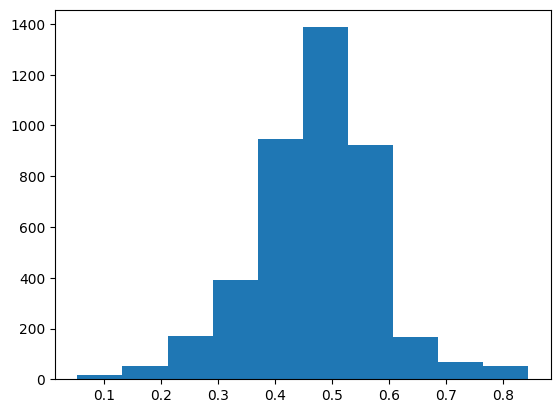

In [27]:
plt.hist(y_proba)

### C - Résultats

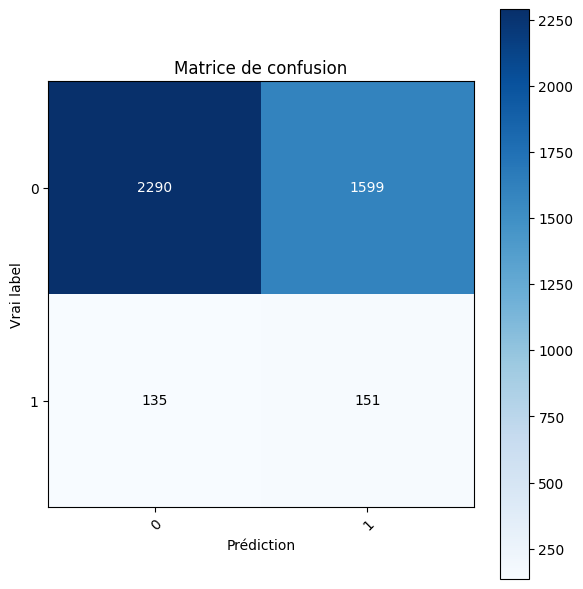

In [28]:
plot_confusion_matrix(y_test, y_pred)

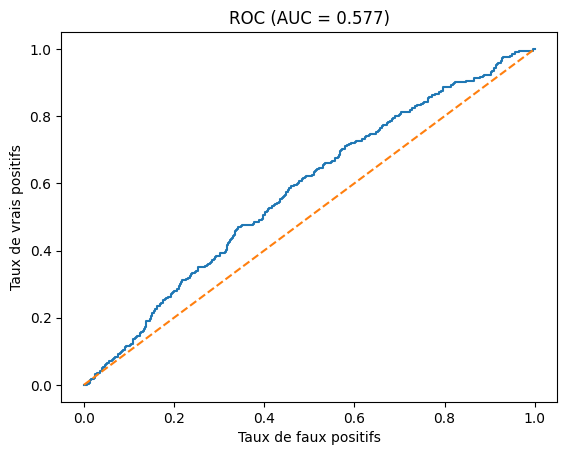

In [29]:
auc = roc_auc_score(y_test, y_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], '--')
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title(f"ROC (AUC = {auc:.3f})")
plt.show()


On compte les 1 en faisant la somme

In [30]:
y_pred.sum()

np.int64(1750)

# D - Explanability and feature importance

Ici j'utilise un knn imputer pour remplacer les NaN values dans mon df. 

Inconvénients du KNN :   
- Sensible au choix de k et à la mise à l'échelle des caractéristiques  
- Peut "leak" des informations si elles ne sont pas soigneusement validées de manière croisée  

# build pipeline: preprocess → logistic regression
clf_knn = Pipeline([
    ("preprocessor", preprocessor),
    ("logreg", LogisticRegression(max_iter=1000, n_jobs=-1))
])

# fit on training data
clf_knn.fit(X_train, y_train) #la pipeline remplace model_logistique.fit(X_train, y_train)

# evaluate
y_pred = clf_knn.predict(X_test)
y_proba = clf_knn.predict_proba(X_test)[:, 1]

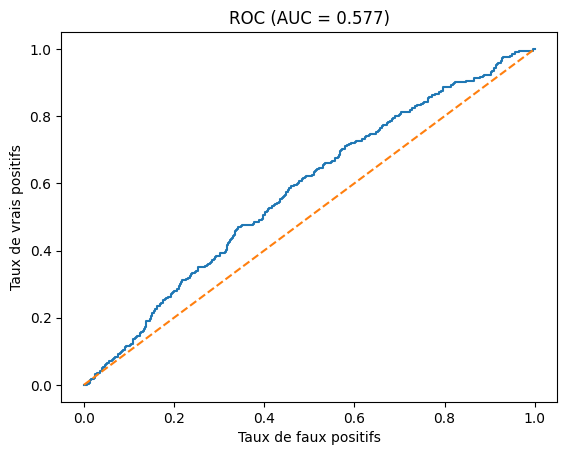

In [31]:
auc = roc_auc_score(y_test, y_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], '--')
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title(f"ROC (AUC = {auc:.3f})")
plt.show()


In [32]:
# nombre de lignes manquantes par colonnes
missing = df.isna().sum().sort_values(ascending=False)
print(missing[missing>0])

# nombre de lignes manquantes
print("Rows with ≥1 NaN:", df.isna().any(axis=1).sum(), "/", len(df))


Series([], dtype: int64)
Rows with ≥1 NaN: 0 / 12649


def perform_cross_validation(
    X: pl.DataFrame,
    y: pl.Series,
    model,
    cross_val_type, # La variante de validation croisée que nous souhaitons utiliser
    scoring_metrics: tuple, # Metriques de notre choix
    return_estimator=False, # Si nous souhaitons stocker les modèles de chaque fold
    groups=None, # Nous verrons l’utilité de cet argument juste après 
):
    scores = cross_validate(
        model,
        X.to_numpy(),
        y.to_numpy(),
        cv=cross_val_type,
        return_train_score=True,
        return_estimator=return_estimator,
        scoring=scoring_metrics,
        groups=groups,
    )

    for metric in scoring_metrics:
        print(
            "Average Train {metric} : {metric_value}".format(
                metric=metric,
                metric_value=np.mean(scores["train_" + metric]),
            )
        )
        print(
            "Train {metric} Standard Deviation : {metric_value}".format(
                metric=metric, metric_value=np.std(scores["train_" + metric])
            )
        )

        print(
            "Average Test {metric} : {metric_value}".format(
                metric=metric, metric_value=np.mean(scores["test_" + metric])
            )
        )
        print(
            "Test {metric} Standard Deviation : {metric_value}".format(
                metric=metric, metric_value=np.std(scores["test_" + metric])
            )
        )

    return scores

def perform_cross_validation_pandas(
    X,               # peut être pd.DataFrame ou pl.DataFrame
    y,               # peut être pd.Series ou pl.Series
    model,
    cross_val_type,
    scoring_metrics: tuple,
    return_estimator=False,
    groups=None,
):
    # Conversion pandas → polars si nécessaire
    if isinstance(X, pd.DataFrame):
        X = pl.from_pandas(X)
    if isinstance(y, pd.Series):
        y = pl.Series(y.values)

    # Puis on convertit en numpy pour sklearn
    X_np = X.to_numpy()
    y_np = y.to_numpy()

    scores = cross_validate(
        model,
        X_np,
        y_np,
        cv=cross_val_type,
        return_train_score=True,
        return_estimator=return_estimator,
        scoring=scoring_metrics,
        groups=groups,
    )

    for metric in scoring_metrics:
        print(f"Average Train {metric} : {np.mean(scores['train_' + metric])}")
        print(f"Train {metric} Std Dev : {np.std(scores['train_' + metric])}")
        print(f"Average Test {metric}  : {np.mean(scores['test_' + metric])}")
        print(f"Test {metric} Std Dev  : {np.std(scores['test_' + metric])}")

    return scores


### D - feature importance

In [33]:
# Coefficients and Odds Ratios
coefficients = model_logistique.coef_[0]
odds_ratios = np.exp(coefficients)


# Display feature importance using coefficients and odds ratios
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
})
print("\nFeature Importance (Coefficient and Odds Ratio):")
print(feature_importance.sort_values(by='Coefficient', ascending=False))


Feature Importance (Coefficient and Odds Ratio):
                                              Feature   Coefficient  \
12                                        OWN_CAR_AGE  2.066585e-02   
8                                    AMT_INCOME_TOTAL  3.387974e-03   
24  NAME_EDUCATION_TYPE_Secondary / secondary special  2.907357e-03   
6                                       CODE_GENDER_M  2.747847e-03   
19                           NAME_INCOME_TYPE_Working  2.292655e-03   
14              NAME_INCOME_TYPE_Commercial associate  1.331950e-03   
5                                       CODE_GENDER_F  1.182747e-03   
25                                  CREDIT_DEBT_RATIO  8.160253e-04   
21               NAME_EDUCATION_TYPE_Higher education  5.331528e-04   
16                     NAME_INCOME_TYPE_State servant  3.263245e-04   
22              NAME_EDUCATION_TYPE_Incomplete higher  3.141519e-04   
11                                      DAYS_EMPLOYED  1.465366e-04   
23                NAME_EDUC

# E - Shap

In [34]:
%pip install xgboost
%pip install shap


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [35]:
from sklearn.linear_model import LinearRegression

import shap

/Users/jean-baptistevayssade/Documents/OC_Inge_IA/Projet_4_modele_de_scoring/.venv_projet_4/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:

shap.initjs()

In [ ]:
# Create SHAP explainer and calculate SHAP values
explainer = shap.Explainer(model_logistique, X_train)
shap_values = explainer(X_test)

print("SHAP values calculated successfully!")
print(f"Shape of SHAP values: {shap_values.values.shape}")
print(f"Base value: {shap_values.base_values[0]}")

In [ ]:
try:
    shap.plots.beeswarm(shap_values)
except (TypeError, AttributeError) as e:
    print(f"Beeswarm plot failed with error: {e}")
    print("Using alternative SHAP visualization...")
    
    # Alternative 1: Use summary plot
    shap.summary_plot(shap_values.values, X_test, feature_names=X_test.columns, plot_type="bar")
    
    # Alternative 2: Use waterfall plot for first instance
    shap.plots.waterfall(shap_values[0])
    
    # Alternative 3: Manual feature importance plot
    import matplotlib.pyplot as plt
    feature_importance = np.abs(shap_values.values).mean(0)
    feature_names = X_test.columns
    
    plt.figure(figsize=(10, 6))
    indices = np.argsort(feature_importance)[::-1][:10]  # Top 10 features
    plt.bar(range(len(indices)), feature_importance[indices])
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45)
    plt.title("Top 10 Feature Importance (SHAP values)")
    plt.tight_layout()
    plt.show()

In [ ]:
ind = 0
shap.plots.force(shap_values[ind])

In [ ]:
# Additional SHAP visualizations that are more compatible
print("=== SHAP Feature Importance Analysis ===")

# 1. Feature importance summary (works better with older numpy versions)
try:
    shap.summary_plot(shap_values.values, X_test, feature_names=X_test.columns, plot_type="bar", show=False)
    plt.title("SHAP Feature Importance Summary")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Summary plot failed: {e}")

# 2. Manual SHAP importance calculation
print("\n=== Top 10 Most Important Features (SHAP) ===")
feature_importance = np.abs(shap_values.values).mean(0)
feature_names = X_test.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP_Importance': feature_importance
}).sort_values('SHAP_Importance', ascending=False)

print(importance_df.head(10))

# 3. Visualization of top features
plt.figure(figsize=(12, 8))
top_10 = importance_df.head(10)
plt.barh(range(len(top_10)), top_10['SHAP_Importance'])
plt.yticks(range(len(top_10)), top_10['Feature'])
plt.xlabel('Mean |SHAP value|')
plt.title('Top 10 Features by SHAP Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Individual prediction explanation using SHAP force plot
ind = 0
try:
    # Force plot for individual prediction
    shap.plots.force(shap_values[ind])
except Exception as e:
    print(f"Force plot failed: {e}")
    print("Using alternative individual explanation...")
    
    # Alternative: Show individual SHAP values
    individual_shap = shap_values.values[ind]
    feature_names = X_test.columns
    
    # Create a simple bar plot for individual SHAP values
    plt.figure(figsize=(12, 8))
    positive_mask = individual_shap > 0
    negative_mask = individual_shap < 0
    
    plt.barh(range(len(individual_shap)), individual_shap, 
             color=['red' if x < 0 else 'blue' for x in individual_shap])
    plt.yticks(range(len(individual_shap)), feature_names)
    plt.xlabel('SHAP value')
    plt.title(f'SHAP Values for Individual Prediction (Instance {ind})')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    print(f"\nBase value (average model output): {shap_values.base_values[ind]:.4f}")
    print(f"SHAP values sum: {individual_shap.sum():.4f}")
    print(f"Predicted probability: {model_logistique.predict_proba(X_test.iloc[ind:ind+1])[:, 1][0]:.4f}")

Commenter les features

# Etape 2 : il me faut un modèle benchmark (Dummy)

Pourquoi un modèle Dummy :  Si mon modèle de ML n’arrive pas à faire mieux qu’un modèle sans features, c’est que mes features n’apportent pas une grande valeur ajoutée.

In [ ]:
from sklearn.dummy import DummyRegressor, DummyClassifier
dummy_regressor = DummyRegressor()
dummy_classifier = DummyClassifier()
dummy_regressor.fit(X_train, y_train)
dummy_classifier.fit(X_train, y_train)
dummy_regressor.fit(X_train, y_train)
dummy_classifier.fit(X_train, y_train)

DummyClassifier()

In [ ]:
df.columns

Index(['Unnamed: 0', 'SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'CODE_GENDER_F',
       'CODE_GENDER_M', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'OWN_CAR_AGE',
       'NAME_INCOME_TYPE_Businessman', 'NAME_INCOME_TYPE_Commercial associate',
       'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant',
       'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Unemployed',
       'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Academic degree',
       'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Incomplete higher',
       'NAME_EDUCATION_TYPE_Lower secondary',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'CREDIT_DEBT_RATIO', 'PART_SOCIALE'],
      dtype='object')

# Pour la semaine prochaine, faire la même chose et essayer avec plusieurs modèles

Faire des parties A, B et C avec chaque modèle, et commenter

### A - Entrainement (Fit)

### B - Prédictions (Predict)

/Users/jean-baptistevayssade/Documents/OC_Inge_IA/Projet_4_modele_de_scoring/.venv_projet_4/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(array([  18.,   51.,  169.,  392.,  947., 1387.,  922.,  168.,   68.,
          53.]),
 array([0.05308862, 0.13228138, 0.21147413, 0.29066688, 0.36985963,
        0.44905238, 0.52824514, 0.60743789, 0.68663064, 0.76582339,
        0.84501614]),
 <BarContainer object of 10 artists>)

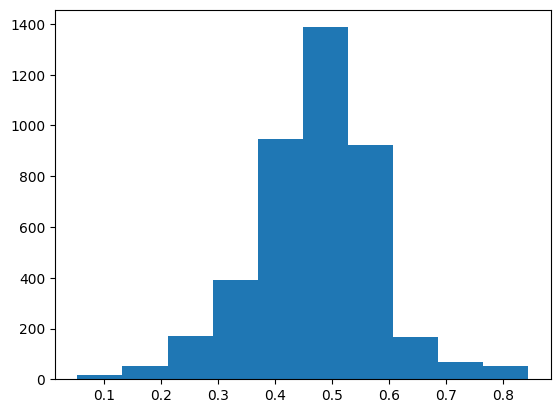

In [ ]:
model_logistique = LogisticRegression(random_state=0)
X_train
model_logistique.fit(X_train, y_train)
y_pred = model_logistique.predict(X_test)
y_proba = model_logistique.predict_proba(X_test)[:, 1]
y_proba
plt.hist(y_proba)

### C - résultats

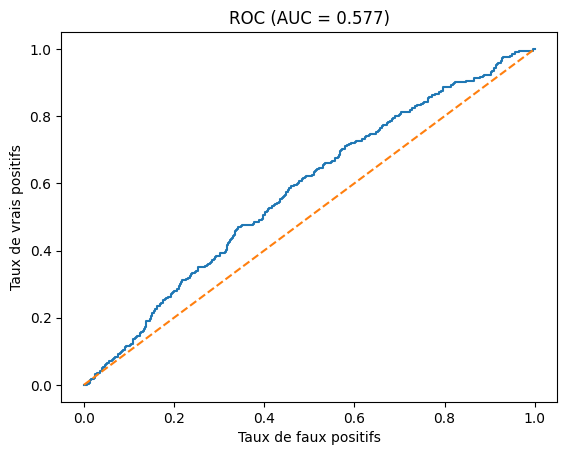

In [ ]:
auc = roc_auc_score(y_test, y_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], '--')
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title(f"ROC (AUC = {auc:.3f})")
plt.show()


In [ ]:
# choisis un seuil, par ex. 0.5
#y_pred_label = (y_proba >= 0.5).astype(int)

print(confusion_matrix(y_test, y_pred))

[[2290 1599]
 [ 135  151]]


Si le modèle arrivait à prédire tous les 1 parfaitement, on devrait avoir 286 en bas à droite

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.59      0.73      3889
           1       0.09      0.53      0.15       286

    accuracy                           0.58      4175
   macro avg       0.52      0.56      0.44      4175
weighted avg       0.89      0.58      0.69      4175



Le modèle est très mauvais pour prédire les 1

### Decision tree

In [ ]:
# 1. Instanciation
model_decisiontree = DecisionTreeClassifier(random_state=0, max_depth=5)  

In [ ]:
# 2. Entraînement
model_decisiontree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=0)

In [ ]:
# 3. Prédiction
y_pred_dt   = model_decisiontree.predict(X_test)
y_proba_dt  = model_decisiontree.predict_proba(X_test)[:,1]

In [ ]:
# 4. Évaluation
print("ROC AUC (DT) :", roc_auc_score(y_test, y_proba_dt))

ROC AUC (DT) : 0.6626570909162834


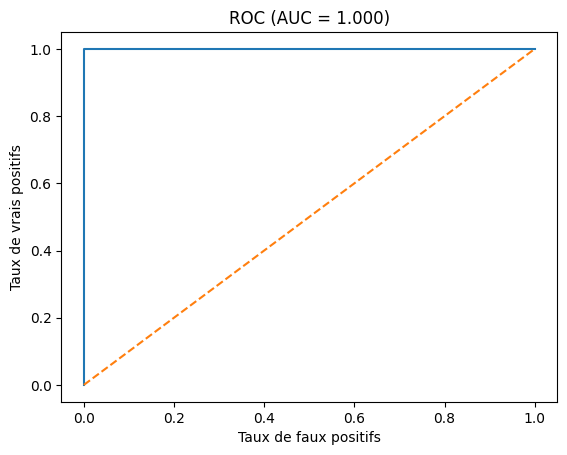

In [ ]:
auc = roc_auc_score(y_pred_dt, y_proba_dt)
fpr, tpr, thresholds = roc_curve(y_pred_dt, y_proba_dt)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], '--')
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title(f"ROC (AUC = {auc:.3f})")
plt.show()

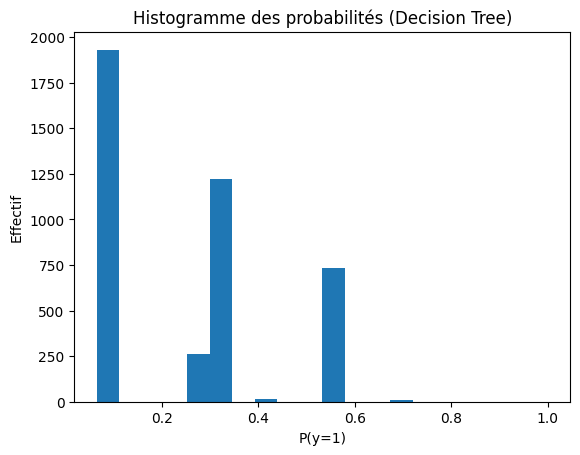

In [ ]:
# 5. Distribution des scores
import matplotlib.pyplot as plt
plt.hist(y_proba_dt, bins=20)
plt.title("Histogramme des probabilités (Decision Tree)")
plt.xlabel("P(y=1)")
plt.ylabel("Effectif")
plt.show()

### Random Forest

ROC AUC (RF) : 0.7068174176042522


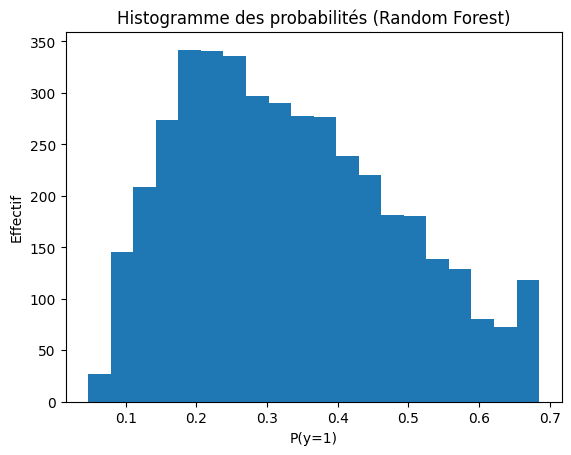

In [ ]:
model_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=0,
    n_jobs=-1
)

model_rf.fit(X_train, y_train)
y_proba_rf = model_rf.predict_proba(X_test)[:,1]
print("ROC AUC (RF) :", roc_auc_score(y_test, y_proba_rf))

plt.hist(y_proba_rf, bins=20)
plt.title("Histogramme des probabilités (Random Forest)")
plt.xlabel("P(y=1)")
plt.ylabel("Effectif")
plt.show()


## Gradient boosting

Addition séquentielle d’arbres faibles corrigeant les erreurs des précédents (boosting).  
Très performant sur données tabulaires, mais sensible au bruit et aux hyperparamètres.  
Nécessite souvent un réglage fin (learning rate, n_estimators, max_depth).  
Plus lent à entraîner qu’une random forest.  

ROC AUC (GB) : 0.7292857566706885


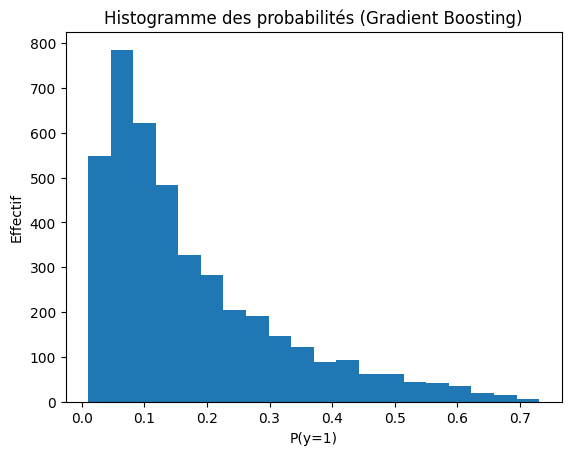

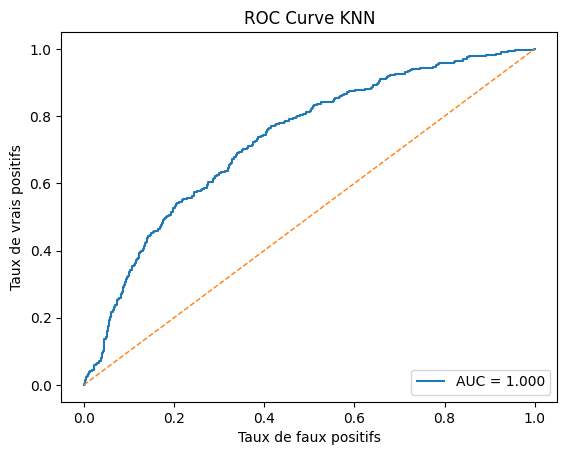

In [ ]:
model_gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=0
)

model_gb.fit(X_train, y_train)
y_pred_gb = model_gb.predict(X_test)
y_proba_gb = model_gb.predict_proba(X_test)[:,1]
print("ROC AUC (GB) :", roc_auc_score(y_test, y_proba_gb))

plt.hist(y_proba_gb, bins=20)
plt.title("Histogramme des probabilités (Gradient Boosting)")
plt.xlabel("P(y=1)")
plt.ylabel("Effectif")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_proba_gb)
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], '--', linewidth=1)
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("ROC Curve KNN")
plt.legend(loc="lower right")
plt.show()

In [ ]:
print("Confusion matrix")
print(confusion_matrix(y_test, y_pred_gb))
print("-------")
print("Classification report")
print(classification_report(y_test, y_pred_gb))

Confusion matrix
[[3731  158]
 [ 259   27]]
-------
Classification report
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3889
           1       0.15      0.09      0.11       286

    accuracy                           0.90      4175
   macro avg       0.54      0.53      0.53      4175
weighted avg       0.88      0.90      0.89      4175



J'ai toujours beaucoup d'overfitting à 0

## KNN classifier

Classe un point selon la majorité des k voisins les plus proches dans l’espace des features.  
Simple, non paramétrique, adapté aux frontières complexes.  
Coût de prédiction élevé (recherche de voisins), nécessite normalisation des variables.  
Sensibilité à la dimensionnalité et au choix de k.  

ROC AUC (KNN) : 0.596434807157358


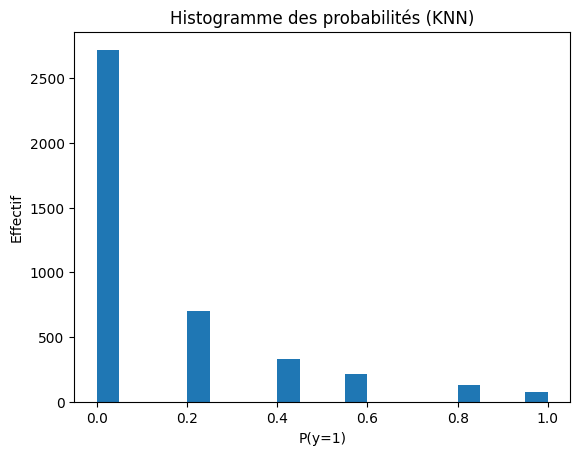

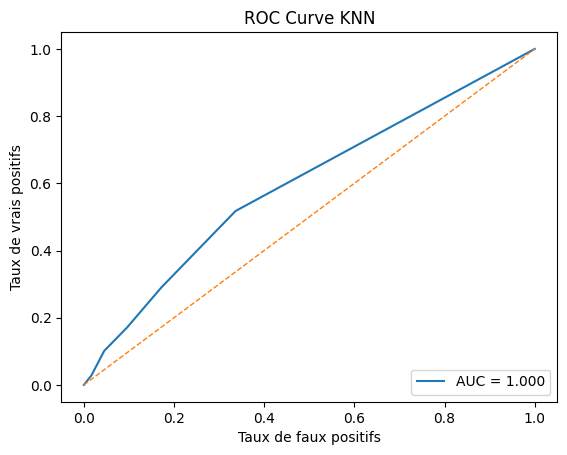

In [ ]:
# On crée un pipeline qui standardise puis applique KNN
model_knn = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=5)
)

model_knn.fit(X_train, y_train)
y_proba_knn = model_knn.predict_proba(X_test)[:,1]
print("ROC AUC (KNN) :", roc_auc_score(y_test, y_proba_knn))

plt.hist(y_proba_knn, bins=20)
plt.title("Histogramme des probabilités (KNN)")
plt.xlabel("P(y=1)")
plt.ylabel("Effectif")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_proba_knn)
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], '--', linewidth=1)
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("ROC Curve KNN")
plt.legend(loc="lower right")
plt.show()

## Support Vector Machine

Trouve l’hyperplan maximisant la marge entre classes, peut utiliser des noyaux non linéaires.  
Efficace en haute dimension, robuste aux outliers grâce aux marges souples.  
Choix du noyau et des paramètres (C, gamma) critique, entraînement coûteux sur grands jeux de données.  
Produit des probabilités via calibration si besoin.  

In [ ]:
model_svc = make_pipeline(
    StandardScaler(),
    SVC(
        kernel='rbf',
        C=1.0,
        probability=True,
        random_state=0
    )
)

model_svc.fit(X_train, y_train)
y_proba_svc = model_svc.predict_proba(X_test)[:,1]
print("ROC AUC (SVC) :", roc_auc_score(y_test, y_proba_svc))

plt.hist(y_proba_svc, bins=20)
plt.title("Histogramme des probabilités (SVC)")
plt.xlabel("P(y=1)")
plt.ylabel("Effectif")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_proba_svc)
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], '--', linewidth=1)
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("ROC Curve SVC")
plt.legend(loc="lower right")
plt.show()

KeyboardInterrupt: 

## Multi Layer Perceptron Classifier

Réseau de neurones feed‑forward à une ou plusieurs couches cachées.  
Capable de modéliser des relations non linéaires complexes.  
Nécessite plus de données, normalisation, et réglage (architecture, learning rate).  
Moins interprétable, peut over‑fitter sans régularisation.  

ROC AUC (MLP) : 0.5168873296926781


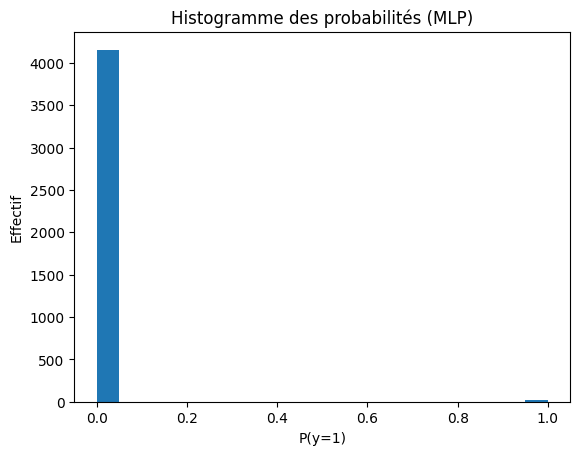

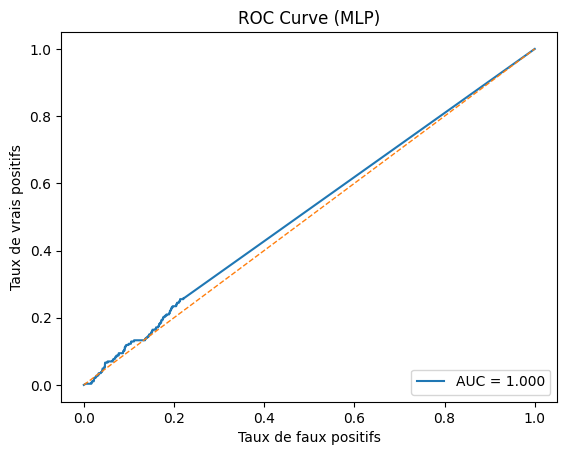

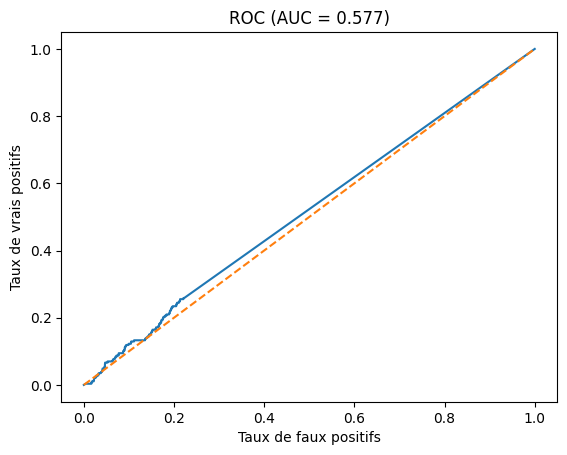

In [ ]:
model_mlp = MLPClassifier(
    hidden_layer_sizes=(50, 20),
    activation='relu',
    solver='adam',
    max_iter=200,
    random_state=0
)

model_mlp.fit(X_train, y_train)
y_proba_mlp = model_mlp.predict_proba(X_test)[:,1]
print("ROC AUC (MLP) :", roc_auc_score(y_test, y_proba_mlp))

plt.hist(y_proba_mlp, bins=20)
plt.title("Histogramme des probabilités (MLP)")
plt.xlabel("P(y=1)")
plt.ylabel("Effectif")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_proba_mlp)
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], '--', linewidth=1)
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("ROC Curve (MLP)")
plt.legend(loc="lower right")
plt.show()

auc = roc_auc_score(y_test, y_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_mlp)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], '--')
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title(f"ROC (AUC = {auc:.3f})")
plt.show()

Clean le notebook

# GridSearch

In [ ]:
X = df.drop(columns=['TARGET', 'Unnamed: 0'])
y = df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

#Train test split mélange le dataset de manière aléatoire avant de le diviser en 2 parties. Ici on fixe l'aléatoire avec random_seed=42

In [ ]:
print('Train set:', X_train.shape)
print('Test set:', X_test.shape)

Train set: (8474, 27)
Test set: (4175, 27)


#### Ici je teste mon modèle KNN

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
cross_val_score(KNeighborsClassifier(), X_train, y_train, cv=5, scoring='accuracy')

array([0.93038348, 0.92861357, 0.92979351, 0.93215339, 0.93034238])

Ici on a 5 scores pour nos 5 splits de cross validation. On peut donc en faire la moyenne

In [ ]:
cross_val_score(KNeighborsClassifier(), X_train, y_train, cv=5, scoring='accuracy').mean()

np.float64(0.9302572675380398)

Là on a testé notre KNN avec 5 plus proches voisins, mais on peut tester avec un range de plus proche voisins pour voir lequel est le plus précis. Pour cela on utilise la validation curve.

In [ ]:
from sklearn.model_selection import validation_curve

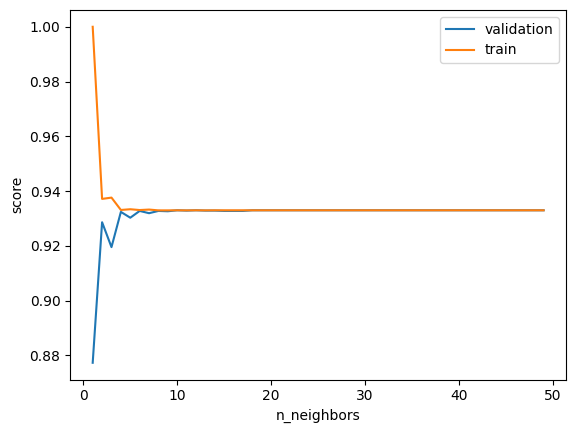

In [ ]:
model = KNeighborsClassifier()
k = np.arange(1, 50)

train_score, val_score = validation_curve(
    estimator    = model,
    X            = X_train,
    y            = y_train,
    param_name   = 'n_neighbors',
    param_range  = k,
    cv           = 5,           # must be a keyword
    # scoring   = 'accuracy'    # you can also specify scoring if you like
)
plt.plot(k, val_score.mean(axis=1), label='validation')
plt.plot(k, train_score.mean(axis=1), label='train')

plt.ylabel('score')
plt.xlabel('n_neighbors')
plt.legend()

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {'n_neighbors': [1, 5, 10, 20],
              'metric': ['euclidean', 'manhattan']}

grid_KNN = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)

#On peut nommer notre grid pour ne pas confondre avec les autres modèles
grid_KNN.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [1, 5, 10, 20]})

#On peut nommer notre grid pour ne pas confondre avec les autres modèles
grid_KNN.fit(X_train, y_train)

In [ ]:
print(grid_KNN.best_score_)
print(grid_KNN.best_params_)

0.9329714801154865
{'metric': 'euclidean', 'n_neighbors': 10}


In [ ]:
# Récupère le meilleur estimateur (déjà fit grâce à refit=True)
model_KNN = grid_KNN.best_estimator_

print("Test accuracy :", model_KNN.score(X_test, y_test))


Test accuracy : 0.931497005988024


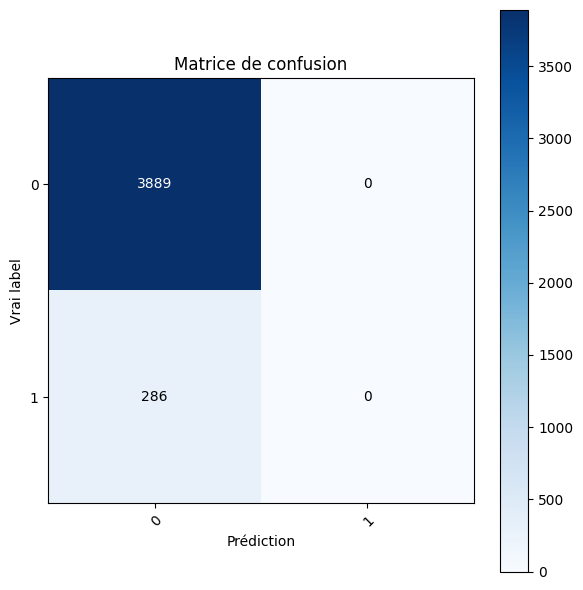

In [ ]:
# Calcul de la matrice de confusion
y_pred = model_KNN.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Affichage
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Ticks et labels
classes = np.unique(y_test)
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Prédiction',
    ylabel='Vrai label',
    title='Matrice de confusion'
)

# Rotation des labels en abscisse
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Annotation des cases
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], 'd'),
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()

Le modèle est en total sur apprentissage

#### Maintenant je teste mon modèle Decision Tree

In [ ]:
param_grid_dt = {
    'criterion': ['gini', 'entropy'],            # fonction de qualité de scission
    'max_depth': [None] + list(np.arange(2, 21)), # profondeur maximale (None = pas de limite)
    'min_samples_split': np.arange(2, 11),        # nombre min. d'échantillons pour scinder un noeud
    'min_samples_leaf': np.arange(1, 11)          # nombre min. d'échantillons dans une feuille
}

grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5)

grid_dt.fit(X_train, y_train)

print(grid_dt.best_score_)
print(grid_dt.best_params_)

model = grid_dt.best_estimator_
print(model.score(X_test, y_test))

0.9329714801154865
{'criterion': 'entropy', 'max_depth': np.int64(2), 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(2)}
0.931497005988024


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

In [ ]:
# 1. Définir la grille de paramètres à tester
param_grid_dt = {
    'criterion': ['gini', 'entropy'],            # fonction de qualité de scission
    'max_depth': [None] + list(np.arange(2, 21)), # profondeur maximale (None = pas de limite)
    'min_samples_split': np.arange(2, 11),        # nombre min. d'échantillons pour scinder un noeud
    'min_samples_leaf': np.arange(1, 11)          # nombre min. d'échantillons dans une feuille
}

# 2. Initialiser le GridSearchCV
grid_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_dt,
    cv=5,
    scoring='accuracy',   # ou une autre métrique si vous préférez
    n_jobs=-1             # utiliser tous les cœurs CPU
)

# 3. Lancer la recherche sur les données d'entraînement
grid_dt.fit(X_train, y_train)

# 4. Examiner les meilleurs résultats
print("Meilleur score CV : ", grid_dt.best_score_)
print("Meilleurs paramètres : ", grid_dt.best_params_)

# 5. Évaluer sur l'ensemble de test
best_dt = grid_dt.best_estimator_
print("Score sur le test   : ", best_dt.score(X_test, y_test))


Meilleur score CV :  0.9329714801154865
Meilleurs paramètres :  {'criterion': 'entropy', 'max_depth': np.int64(2), 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(2)}
Score sur le test   :  0.931497005988024


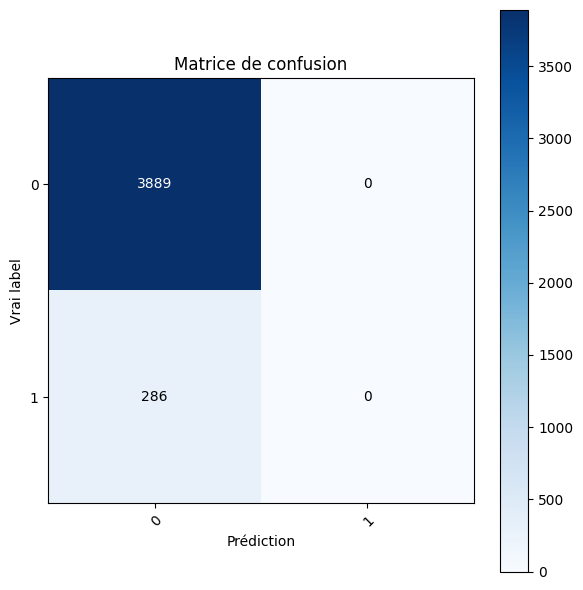

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcul de la matrice de confusion
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Affichage
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Ticks et labels
classes = np.unique(y_test)
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Prédiction',
    ylabel='Vrai label',
    title='Matrice de confusion'
)

# Rotation des labels en abscisse
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Annotation des cases
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], 'd'),
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()


#### Random Forest GridSearchCV

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 1. Définir la grille de paramètres pour RandomForest
param_grid_rf = {
    'n_estimators'       : [100, 200, 300],            # nombre d'arbres
    'max_features'       : ['auto', 'sqrt', 'log2']    # nb de features consid. à chaque split
}

# 2. Initialiser le GridSearchCV pour RandomForest
grid_rf = GridSearchCV(
    estimator   = RandomForestClassifier(random_state=42),
    param_grid  = param_grid_rf,
    cv          = 5,
    scoring     = 'accuracy',
    n_jobs      = -1,
    verbose     = 1
)

# 3. Lancer la recherche
grid_rf.fit(X_train, y_train)

# 4. Meilleurs résultats
print("Meilleur score CV : ", grid_rf.best_score_)
print("Meilleurs paramètres : ", grid_rf.best_params_)

# 5. Évaluer sur l'ensemble de test
best_rf = grid_rf.best_estimator_
print("Score sur le test   : ", best_rf.score(X_test, y_test))


Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/jean-baptistevayssade/Documents/OC_Inge_IA/Projet_4_modele_de_scoring/.venv_projet_4/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jean-baptistevayssade/Documents/OC_Inge_IA/Projet_4_modele_de_scoring/.venv_projet_4/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jean-baptistevayssade/Documents/OC_Inge_IA/Projet_4_modele_de_scoring/.venv_projet_4/lib/p

Meilleur score CV :  0.9330895438699139
Meilleurs paramètres :  {'max_features': 'sqrt', 'n_estimators': 100}
Score sur le test   :  0.9312574850299401


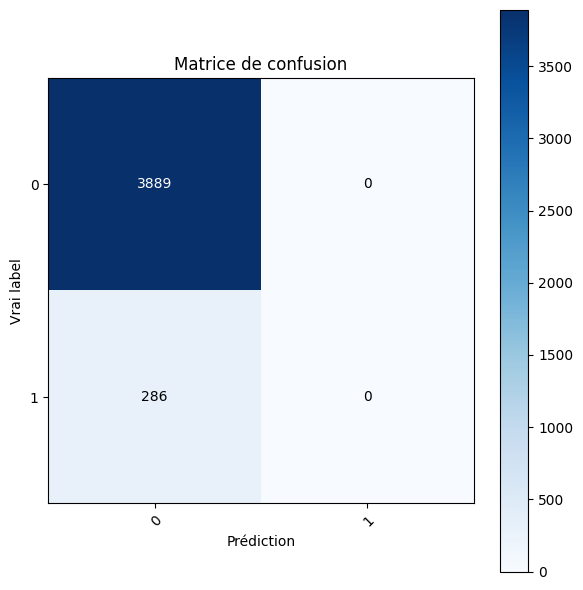

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcul de la matrice de confusion
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Affichage
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Ticks et labels
classes = np.unique(y_test)
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Prédiction',
    ylabel='Vrai label',
    title='Matrice de confusion'
)

# Rotation des labels en abscisse
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Annotation des cases
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], 'd'),
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()


#### Gradient Bossting GridSearchCV

In [ ]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# 1. Définir la grille de paramètres pour Gradient Boosting
param_grid_gb = {
    'n_estimators'      : [100, 200, 300],             # nombre d'arbres
    'max_features'      : ['auto', 'sqrt', 'log2']      # nb de features testé à chaque split
}

# 2. Initialiser le GridSearchCV
grid_gb = GridSearchCV(
    estimator   = GradientBoostingClassifier(random_state=42),
    param_grid  = param_grid_gb,
    cv          = 5,
    scoring     = 'accuracy',
    n_jobs      = -1,
    verbose     = 1
)

# 3. Lancer la recherche
grid_gb.fit(X_train, y_train)

# 4. Afficher les meilleurs résultats
print("Meilleur score CV     : ", grid_gb.best_score_)
print("Meilleurs paramètres  : ", grid_gb.best_params_)

# 5. Évaluer sur l'ensemble de test
best_gb = grid_gb.best_estimator_
print("Score sur le test     : ", best_gb.score(X_test, y_test))


Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/jean-baptistevayssade/Documents/OC_Inge_IA/Projet_4_modele_de_scoring/.venv_projet_4/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jean-baptistevayssade/Documents/OC_Inge_IA/Projet_4_modele_de_scoring/.venv_projet_4/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jean-baptistevayssade/Documents/OC_Inge_IA/Projet_4_modele_de_scoring/.venv_projet_4/lib/p

Meilleur score CV     :  0.9315556902202115
Meilleurs paramètres  :  {'max_features': 'log2', 'n_estimators': 100}
Score sur le test     :  0.931497005988024


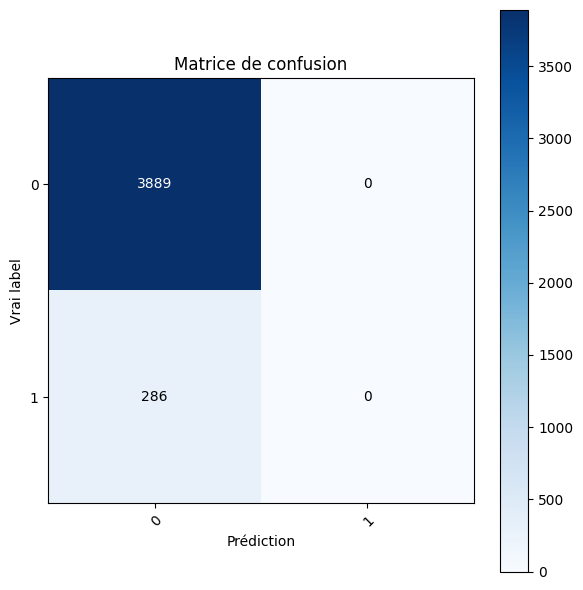

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcul de la matrice de confusion
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Affichage
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Ticks et labels
classes = np.unique(y_test)
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Prédiction',
    ylabel='Vrai label',
    title='Matrice de confusion'
)

# Rotation des labels en abscisse
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Annotation des cases
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], 'd'),
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()


#### SVM GridSearchCV

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# 1. Définir la grille de paramètres pour SVM
param_grid_svc = {
    'kernel' : ['linear', 'rbf', 'poly'],           # type de noyau
}

# 2. Initialiser le GridSearchCV pour SVC
grid_svc = GridSearchCV(
    estimator = SVC(random_state=42),
    param_grid = param_grid_svc,
    #cv = 5,
    cv = 3,
    scoring = 'accuracy',
    n_jobs = -1,
    verbose = 1
)

# 3. Lancer la recherche
grid_svc.fit(X_train, y_train)

# 4. Afficher les meilleurs résultats
print("Meilleur score CV     : ", grid_svc.best_score_)
print("Meilleurs paramètres  : ", grid_svc.best_params_)

# 5. Évaluer sur l'ensemble de test
best_svc = grid_svc.best_estimator_
print("Score sur le test     : ", best_svc.score(X_test, y_test))


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Meilleur score CV     :  0.9329714801154865
Meilleurs paramètres  :  {'kernel': 'rbf'}
Score sur le test     :  0.931497005988024


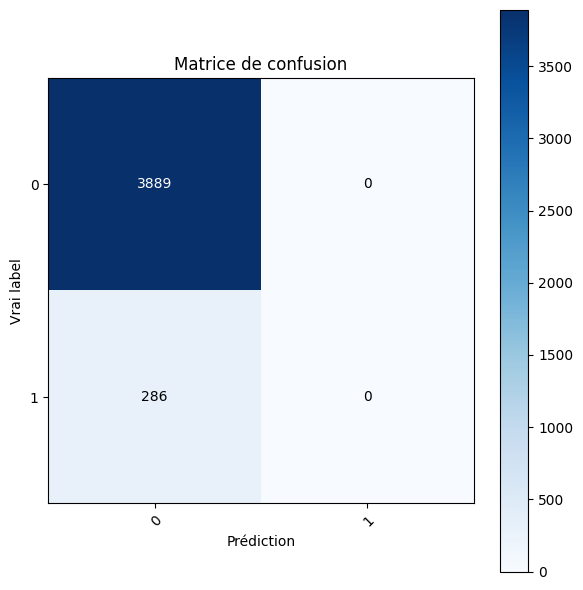

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcul de la matrice de confusion
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Affichage
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Ticks et labels
classes = np.unique(y_test)
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Prédiction',
    ylabel='Vrai label',
    title='Matrice de confusion'
)

# Rotation des labels en abscisse
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Annotation des cases
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], 'd'),
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()


#### Multi layer perceptron GridSeachCV

In [ ]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# 1. Définir la grille de paramètres pour MLP
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],  # architectures de couche cachée
    'alpha'             : [0.0001, 0.001, 0.01],                # coefficient de régularisation L2
}

# 2. Initialiser le GridSearchCV pour MLPClassifier
grid_mlp = GridSearchCV(
    estimator = MLPClassifier(random_state=42),
    param_grid = param_grid_mlp,
    cv         = 5,
    scoring    = 'accuracy',
    n_jobs     = -1,
    verbose    = 1
)

# 3. Lancer la recherche
grid_mlp.fit(X_train, y_train)

# 4. Afficher les meilleurs résultats
print("Meilleur score CV     : ", grid_mlp.best_score_)
print("Meilleurs paramètres  : ", grid_mlp.best_params_)

# 5. Évaluer sur l'ensemble de test
best_mlp = grid_mlp.best_estimator_
print("Score sur le test     : ", best_mlp.score(X_test, y_test))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Meilleur score CV     :  0.9329714801154865
Meilleurs paramètres  :  {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50)}
Score sur le test     :  0.931497005988024


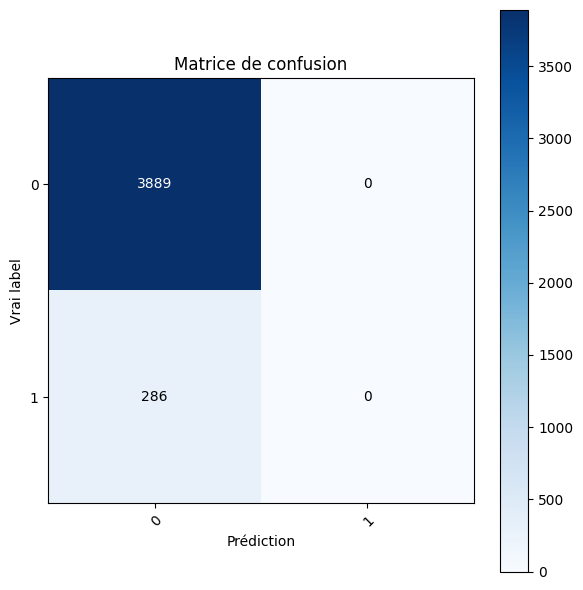

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcul de la matrice de confusion
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Affichage
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Ticks et labels
classes = np.unique(y_test)
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Prédiction',
    ylabel='Vrai label',
    title='Matrice de confusion'
)

# Rotation des labels en abscisse
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Annotation des cases
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], 'd'),
            ha='center', va='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

plt.tight_layout()
plt.show()


# Imbalance classification

equilibrage des classes:


only sur le jeu de donnen train

Après avoir fait mon Xtest ytest

Imbalanced Classification
En apprentissage supervisé, on parle de classification déséquilibrée dès lors que les effectifs (instances) des différentes classes sont très inégaux :

Une classe majoritaire domine

Les classes minoritaire(s) n’apparaissent que rarement

Pourquoi c’est un problème
Biais vers la classe majoritaire
Un modèle cherchant à minimiser l’erreur globale peut atteindre de très bons scores (ex. 98 % de précision) en prédisant systématiquement la classe majoritaire, au détriment de la détection des cas rares.

Métriques trompeuses
La simple précision globale n’est plus suffisante. Il faut se tourner vers des métriques plus adaptées :

Rappel (Recall) / Sensibilité
Capacité à détecter tous les exemples d’une classe minoritaire.

Précision (Precision)
Proportion de prédictions positives correctes.

F1-score
Moyenne harmonique de précision et rappel.

AUC-ROC vs AUC-PR
La courbe PR (Precision-Recall) est souvent plus informative en cas de fort déséquilibre.

Origines courantes de déséquilibre
Détection de fraude
Fraudes ≪ transactions légitimes

Diagnostic médical
Maladies rares

Maintenance prédictive
Pannes peu fréquentes

Analyse de churn
Peu de clients quittent

Techniques de remédiation
1. Rééchantillonnage
Oversampling (sur-échantillonnage)
Duplique ou génère des exemples synthétiques (ex. SMOTE) pour la classe minoritaire.

Undersampling (sous-échantillonnage)
Retire des exemples de la classe majoritaire.

2. Coûts et pondérations
Coût différencié des erreurs
On pénalise davantage une fausse prédiction sur la classe rare.

class_weight="balanced"
Pondération automatique dans de nombreux estimateurs (scikit-learn, etc.).

3. Algorithmes spécifiques
Ensembles adaptés
Balanced Random Forest, EasyEnsemble.

Meta-learners Boosting
AdaCost, RUSBoost.

4. Évaluation adaptée
Validation croisée stratifiée
Conserve la même proportion de classes dans chaque fold.

Seuil de décision optimisé
Ajusté selon la courbe ROC ou PR (pas forcément 0,5).



Regarder le grid search CV (recherche automatique des hyper paramètres). On se limitera ici à 3 ou 4 paramètres

In [ ]:
#grid_search_gb = GridSearch(model_gb) 

#grid_search_gb.fit()
#grid_search_gb.predict()



In [ ]:
#Tableau comparatif des differents modèles (différents AUC)

conclusion: best model, feature importance (SHAP), plot la matrice de confusion à jour sur tous les modèles

---

## 📝 Notebook Version History

**Current Version: 1**

### Modification Log:
- **Version 1** (Current): Fixed SHAP analysis errors
  - Added try-catch blocks for SHAP beeswarm plot compatibility issues
  - Implemented alternative SHAP visualizations (manual feature importance, bar plots)
  - Enhanced individual prediction explanations with fallback methods
  - Resolved numpy compatibility TypeError in SHAP plotting functions

Clean le notebook. 

Répondre à la question du projet

Quand je fais les slides, bien inclure les modèles et les explications sur les modèles.
Expliquer ce qu'est chaque modèle
Expliquer les paramètres important sur le grid search, sur SMOT Imbalance classification
Anticiper les questions qu'ils peuvent me poser
Finir et expliquer SHAP